# CNN Design 

We have previously implemented a simple three layer CNN (CONV-FC-FC-Softmax) and started on implemented deeper CNNs with the following architecture:

{{conv - relu} x L - max pool} x B - affine - relu - affine - softmax

But we discovered that test and validation accuracy flattens out when L and B exceeds 2. We believe this is is due to vanishing gradient.

In this Notebook, we will quantify the vanishing gradient issue, and then implement methodologies to allow us to build deeper networks.

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.classifiers.convnet1 import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000L, 3L, 32L, 32L)
X_train:  (49000L, 3L, 32L, 32L)
X_test:  (1000L, 3L, 32L, 32L)
y_val:  (1000L,)
y_train:  (49000L,)
y_test:  (1000L,)


# Five Layer CNN

We will deepen the number of CONV layers in cnn.py and implement ways to address vanishing gradient problems.

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

## Vanishing Gradient Issue

CONV Layer 1 output mean: 0.004575 std: 0.006764  
CONV Layer 2 output mean: 0.000110 std: 0.000170  
** CONV Layer 3 output mean: 0.000006 std: 0.000006 **  
** FC Layer 1 output mean: 0.000000 std: 0.000000 **

In [38]:
from cs231n.classifiers.cnn import *

model = FiveLayerConvNet(verbose=True, xavier=True)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

scores = model.loss(X, debug=True)

loss, grads = model.loss(X, y, debug=True)
print 'Initial loss (no regularization): ', loss

model.reg = 0.5
loss, grads = model.loss(X, y)
print 'Initial loss (with regularization): ', loss

This outlines the architecture of the 5 layer CNN:
input dimension: 3 x 32 x 32
W & b in CONV-ReLU layers:
(32L, 3L, 7L, 7L)
(32L,)
(32L, 32L, 7L, 7L)
(32L,)
(32L, 32L, 7L, 7L)
(32L,)
W & b in FC layers:
(8192L, 100L)
(100L,)
(100L, 10L)
(10L,)


CONV Layer 1 output mean: 0.531177  std: 0.786027
CONV Layer 2 output mean: 0.663002  std: 0.876407
CONV Layer 3 output mean: 0.976796  std: 0.926983
FC Layer 1 output mean: 0.041318  std: 0.065212
CONV Layer 1 output mean: 0.531177  std: 0.786027
CONV Layer 2 output mean: 0.663002  std: 0.876407
CONV Layer 3 output mean: 0.976796  std: 0.926983
FC Layer 1 output mean: 0.041318  std: 0.065212
Initial loss (no regularization):  2.30268875486
Initial loss (with regularization):  50.4692303001


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

## Vanishing Gradient Problem

Vanishing gradient problem can manifest itself during gradient check:

W1 max relative error: 2.121366e-02  
W2 max relative error: 2.182969e-02  
W3 max relative error: 2.402535e-02  
W4 max relative error: 1.097493e-02  
W5 max relative error: 2.810550e-02  
b1 max relative error: 2.182924e-02  
b2 max relative error: 2.631683e-01  
b3 max relative error: 8.499028e-01  
** b4 max relative error: 1.000000e+00 **  
b5 max relative error: 1.402320e-09  

In [40]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = FiveLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64,xavier=True)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 1.848055e-04
W2 max relative error: 5.149407e-04
W3 max relative error: 5.151576e-04
W4 max relative error: 1.545741e-05
W5 max relative error: 9.303588e-07
b1 max relative error: 1.968365e-05
b2 max relative error: 1.127173e-05
b3 max relative error: 2.925038e-05
b4 max relative error: 2.432267e-05
b5 max relative error: 1.270612e-09


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

## Vanishing Gradient - during Training

The problem can manifest itself in slowness to achieving high training accuracy for small data sets:

(Iteration 1 / 20) loss: 2.311788  
(Epoch 0 / 10) train acc: 0.130000; val_acc: 0.079000  
(Iteration 2 / 20) loss: 2.311951  
(Epoch 1 / 10) train acc: 0.160000; val_acc: 0.117000  
(Iteration 3 / 20) loss: 2.272113  
(Iteration 4 / 20) loss: 2.144765  
(Epoch 2 / 10) train acc: 0.270000; val_acc: 0.141000  
(Iteration 5 / 20) loss: 2.246346  
(Iteration 6 / 20) loss: 2.165624  
(Epoch 3 / 10) train acc: 0.210000; val_acc: 0.127000  
(Iteration 7 / 20) loss: 2.124104  
(Iteration 8 / 20) loss: 2.004004  
(Epoch 4 / 10) train acc: 0.250000; val_acc: 0.150000  
(Iteration 9 / 20) loss: 1.979979  
(Iteration 10 / 20) loss: 1.901551  
(Epoch 5 / 10) train acc: 0.280000; val_acc: 0.159000  
(Iteration 11 / 20) loss: 1.942026  
(Iteration 12 / 20) loss: 1.866108  
(Epoch 6 / 10) train acc: 0.390000; val_acc: 0.177000  
(Iteration 13 / 20) loss: 1.877042  
(Iteration 14 / 20) loss: 1.515089  
(Epoch 7 / 10) train acc: 0.460000; val_acc: 0.193000  
(Iteration 15 / 20) loss: 1.531506  
(Iteration 16 / 20) loss: 0.980025  
(Epoch 8 / 10) train acc: 0.580000; val_acc: 0.178000  
(Iteration 17 / 20) loss: 1.407415  
(Iteration 18 / 20) loss: 1.765679  
(Epoch 9 / 10) train acc: 0.710000; val_acc: 0.210000  
(Iteration 19 / 20) loss: 1.007402  
(Iteration 20 / 20) loss: 1.171184  
(Epoch 10 / 10) train acc: 0.730000; val_acc: 0.174000  

In [42]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = FiveLayerConvNet(weight_scale=1e-2, verbose=False, xavier=True)

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 20) loss: 5.628032
(Epoch 0 / 10) train acc: 0.140000; val_acc: 0.084000
(Iteration 2 / 20) loss: 4.411746
(Epoch 1 / 10) train acc: 0.240000; val_acc: 0.102000
(Iteration 3 / 20) loss: 3.683986
(Iteration 4 / 20) loss: 4.164215
(Epoch 2 / 10) train acc: 0.350000; val_acc: 0.126000
(Iteration 5 / 20) loss: 3.309058
(Iteration 6 / 20) loss: 3.250493
(Epoch 3 / 10) train acc: 0.370000; val_acc: 0.132000
(Iteration 7 / 20) loss: 2.679466
(Iteration 8 / 20) loss: 2.337913
(Epoch 4 / 10) train acc: 0.520000; val_acc: 0.120000
(Iteration 9 / 20) loss: 1.845288
(Iteration 10 / 20) loss: 1.292486
(Epoch 5 / 10) train acc: 0.530000; val_acc: 0.128000
(Iteration 11 / 20) loss: 1.625628
(Iteration 12 / 20) loss: 1.477513
(Epoch 6 / 10) train acc: 0.670000; val_acc: 0.137000
(Iteration 13 / 20) loss: 1.243227
(Iteration 14 / 20) loss: 1.328669
(Epoch 7 / 10) train acc: 0.690000; val_acc: 0.173000
(Iteration 15 / 20) loss: 1.150173
(Iteration 16 / 20) loss: 1.099195
(Epoch 8 / 10) tr

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

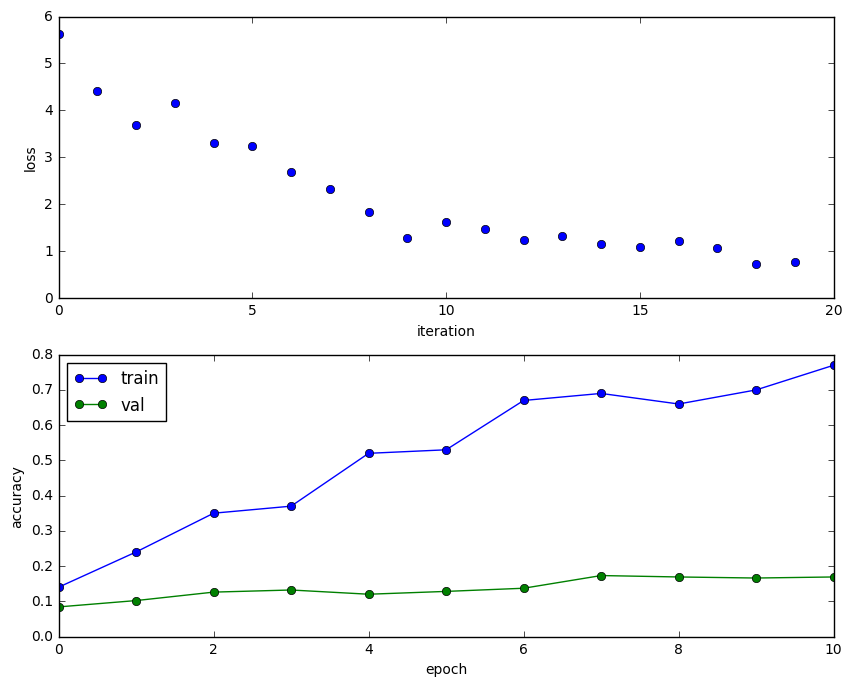

In [43]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Train a 5 Layer CNN

The 5 layer network is configured as followed:  

CONV32x7x7-ReLU - CONV32x7x7-ReLU - CONV32x7x7-ReLU - Maxpool - FC-ReLU - FC - Softmax  

(trained for 1 epochs full training dataset)
** (Epoch 1 / 1) train acc: 0.606000; val_acc: 0.581000 **
Training Time: 3415.146000s

This compares with the following for 3 Layer networks (trained for 2 epochs full training dataset):  

32 Filters of size 3 (Run 0) val accuracy: 0.419000  (approx. 1200 sec)
32 Filters of size 3 (Run 0) val accuracy: 0.430000  
128 Filters of size 3 (Run 0) val accuracy: 0.488000  (approx 4300 sec)
128 Filters of size 3 (Run 0) val accuracy: 0.472000  
128 Filters of size 3 (Run 0) val accuracy: 0.434000  
128 Filters of size 3 (Run 0) val accuracy: 0.619000  
128 Filters of size 3 (Run 0) val accuracy: 0.586000  
128 Filters of size 3 (Run 0) val accuracy: 0.493000  
128 Filters of size 3 (Run 0) val accuracy: 0.529000  
128 Filters of size 3 (Run 0) val accuracy: 0.511000  
128 Filters of size 3 (Run 0) val accuracy: 0.493000  
** best validation accuracy achieved during cross-validation: 0.619000 **

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [48]:
model = FiveLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, xavier=True)

t1 = time()
solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=20)
solver.train()
t2 = time()

print 'Training Time: %fs' % (t2 - t1)

(Iteration 1 / 980) loss: 2.405648
(Epoch 0 / 1) train acc: 0.091000; val_acc: 0.113000
(Iteration 21 / 980) loss: 2.223582
(Iteration 41 / 980) loss: 2.005126
(Iteration 61 / 980) loss: 1.773930
(Iteration 81 / 980) loss: 1.683117
(Iteration 101 / 980) loss: 2.070622
(Iteration 121 / 980) loss: 1.646039
(Iteration 141 / 980) loss: 1.517746
(Iteration 161 / 980) loss: 1.412551
(Iteration 181 / 980) loss: 1.564619
(Iteration 201 / 980) loss: 1.604446
(Iteration 221 / 980) loss: 1.433556
(Iteration 241 / 980) loss: 1.598941
(Iteration 261 / 980) loss: 1.354538
(Iteration 281 / 980) loss: 1.634323
(Iteration 301 / 980) loss: 1.719703
(Iteration 321 / 980) loss: 1.447970
(Iteration 341 / 980) loss: 1.247339
(Iteration 361 / 980) loss: 1.534680
(Iteration 381 / 980) loss: 1.557603
(Iteration 401 / 980) loss: 1.292029
(Iteration 421 / 980) loss: 1.297774
(Iteration 441 / 980) loss: 1.488886
(Iteration 461 / 980) loss: 1.292179
(Iteration 481 / 980) loss: 1.553414
(Iteration 501 / 980) loss: 

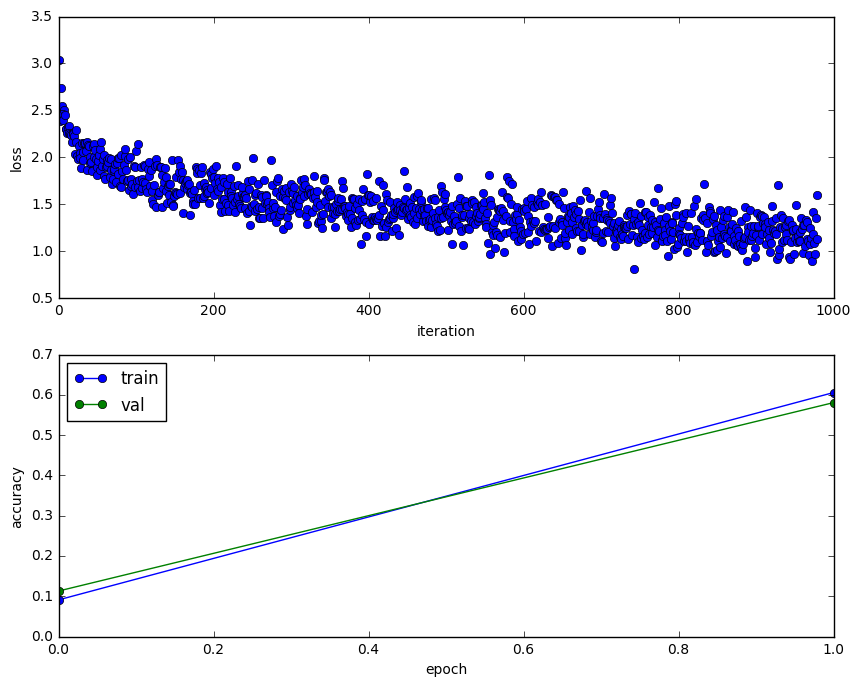

In [49]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='best')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

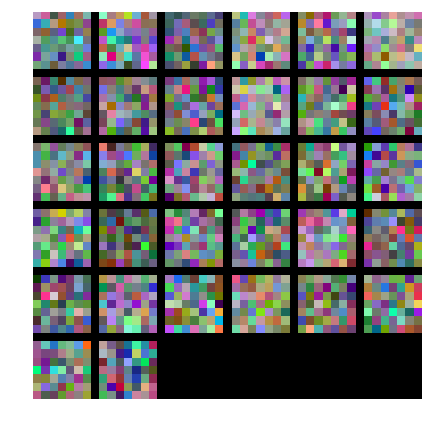

In [52]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Train a 3 Layer CNN with Batch Norm and Dropoff

The 3 layer network is configured as followed:

CONV32-(Bn)-ReLU- Maxpool - FC-(Bn)-ReLU-(DO) - FC - Softmax

where Batch Normalization and Dropoff are optional. Note also that Dropoff is only implemented for the FC-ReLU layer.

## Sanity check loss

After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about log(C) for C classes. When we add regularization this should go up.

In [97]:
model = ThreeLayerConvNet(dropout=0.75, seed=123, use_batchnorm=True, verbose=True)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print 'Initial loss (no regularization): ', loss

model.reg = 0.5
loss, grads = model.loss(X, y)
print 'Initial loss (with regularization): ', loss

This outlines the architecture of the 5 layer CNN:
input dimension: 3 x 32 x 32
W & b in CONV-ReLU layers:
(64L, 3L, 3L, 3L)
(64L,)
Gamma and Beta in CONV-ReLU layers:
(64L,)
(64L,)
W & b in FC layer:
(16384L, 200L)
(200L,)
Gamma and Beta in FC layers:
(200L,)
(200L,)
W & b in FC layer:
(200L, 10L)
(10L,)


BN parameters for CONV and FC1:
[{'mode': 'train'}, {'mode': 'train'}]
dropout parameters:
{'p': 0.75, 'seed': 123, 'mode': 'train'}
Initial loss (no regularization):  2.30308218584
Initial loss (with regularization):  3.12397090222


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [102]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dropout=0.50, seed=123, use_batchnorm=True,
                          dtype=np.float64, verbose=True)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

This outlines the architecture of the 5 layer CNN:
input dimension: 3 x 16 x 16
W & b in CONV-ReLU layers:
(3L, 3L, 3L, 3L)
(3L,)
Gamma and Beta in CONV-ReLU layers:
(3L,)
(3L,)
W & b in FC layer:
(192L, 7L)
(7L,)
Gamma and Beta in FC layers:
(7L,)
(7L,)
W & b in FC layer:
(7L, 10L)
(10L,)


BN parameters for CONV and FC1:
[{'mode': 'train'}, {'mode': 'train'}]
dropout parameters:
{'p': 0.5, 'seed': 123, 'mode': 'train'}
W1 max relative error: 1.876928e-01
W2 max relative error: 6.778057e-06
W3 max relative error: 3.258636e-09
b1 max relative error: 1.526557e-08
b2 max relative error: 1.387779e-09
b3 max relative error: 9.877306e-10
beta1 max relative error: 2.565666e-07
beta2 max relative error: 4.993791e-07
gamma1 max relative error: 1.610993e-07
gamma2 max relative error: 2.350060e-06


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [5]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2, dropout=0.5, seed=123, use_batchnorm=True, verbose=False)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=1)
solver.train()

f = open('workfile', 'w')
print solver.best_params

(Iteration 1 / 40) loss: 2.311645
(Epoch 0 / 20) train acc: 0.150000; val_acc: 0.101000
(Iteration 2 / 40) loss: 2.293846
(Epoch 1 / 20) train acc: 0.300000; val_acc: 0.129000
(Iteration 3 / 40) loss: 2.117249
(Iteration 4 / 40) loss: 2.159566
(Epoch 2 / 20) train acc: 0.420000; val_acc: 0.171000
(Iteration 5 / 40) loss: 1.864430
(Iteration 6 / 40) loss: 1.990164
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.190000
(Iteration 7 / 40) loss: 1.723558
(Iteration 8 / 40) loss: 1.851654
(Epoch 4 / 20) train acc: 0.450000; val_acc: 0.187000
(Iteration 9 / 40) loss: 1.628168
(Iteration 10 / 40) loss: 1.745673
(Epoch 5 / 20) train acc: 0.500000; val_acc: 0.194000
(Iteration 11 / 40) loss: 1.553687
(Iteration 12 / 40) loss: 1.658678
(Epoch 6 / 20) train acc: 0.550000; val_acc: 0.201000
(Iteration 13 / 40) loss: 1.490952
(Iteration 14 / 40) loss: 1.583327
(Epoch 7 / 20) train acc: 0.630000; val_acc: 0.204000
(Iteration 15 / 40) loss: 1.434623
(Iteration 16 / 40) loss: 1.516659
(Epoch 8 / 20) tr

# Saving Model Parameters into a File

In [26]:
outfile = 'modelparams.npz'
np.savez(outfile, **model.params)

npzfile = np.load(outfile)
print('npzfile.files: {}'.format(npzfile.files))
print('npzfile["W1"]: {}'.format(npzfile["W1"]))

npzfile.files: ['b2', 'gamma1', 'gamma2', 'W3', 'b1', 'beta1', 'b3', 'beta2', 'W1', 'W2']
npzfile["W1"]: [[[[  9.66310681e-03   4.71575190e-03  -5.16830490e-03]
   [  1.02572524e-02   3.08763412e-03   1.67589776e-03]
   [ -1.45819678e-03   2.41493985e-03   7.43737688e-03]]

  [[ -2.07991474e-02  -1.29412768e-02   3.64898162e-04]
   [ -8.63738216e-04  -9.89012676e-03   5.62551245e-03]
   [ -1.83740925e-02   8.96671811e-03   8.37988798e-03]]

  [[ -6.24479107e-03  -6.64169158e-04  -4.51654985e-03]
   [ -3.83696344e-03   7.94065600e-03   7.04282267e-03]
   [  3.07613893e-04  -1.83782332e-02   1.84371031e-02]]]


 [[[  4.79882598e-03  -5.31402480e-03   1.34389254e-02]
   [ -9.32405905e-03  -1.12299736e-02   1.47164787e-02]
   [  2.62067428e-03  -1.15537738e-03   1.83576129e-03]]

  [[  7.49927967e-03  -3.64140121e-03  -1.38402411e-02]
   [  1.43074352e-02   3.04399348e-03   8.38723439e-03]
   [ -8.23688466e-03   3.92591372e-03  -1.91215029e-02]]

  [[ -6.11137921e-03   8.10705847e-05   5.5

In [68]:
best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

num_train = 10000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
batchnorm = {'Yes':True, 'No':False}

learning_rates = [1e-4]
regularization_strengths = [0.0001]

for label, bn in batchnorm.iteritems():
    print 'Batch Norm:', label
    for i in range(1):
        print 'Run number: %d '% i
        version = 1
        for lr in learning_rates:
            for reg in regularization_strengths:
                print 'Learning rate: %e Reg Strength: %e '% (lr, reg)
                model = ThreeLayerConvNet(num_filters=128, filter_size=3, 
                                          hidden_dim=500, reg=reg, 
                                          weight_scale=1e-2, use_batchnorm=bn, verbose=False)

                t1 = time()               
                solver = Solver(model, data,
                    num_epochs=5, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },verbose=True, print_every=5)
                solvers[(label,i,version,lr,reg)] = solver
                solver.train()
                t2 = time()

                times[(label,i,version,lr,reg)] = (t2 - t1)
                print 'Training Time: %fs' % (t2 - t1)
        
                results[(label,i,version,lr,reg)] = solver.best_val_acc
  
                if (solver.best_val_acc > best_val):
                    best_val = solver.best_val_acc
                    best_model = model
            
                version += 1

Batch Norm: Yes
Run number: 0 
Learning rate: 1.000000e-04 Reg Strength: 1.000000e-04 
(Iteration 1 / 4900) loss: 2.413768
(Epoch 0 / 5) train acc: 0.185000; val_acc: 0.183000
(Iteration 6 / 4900) loss: 2.187365
(Iteration 11 / 4900) loss: 2.041419
(Iteration 16 / 4900) loss: 2.121142
(Iteration 21 / 4900) loss: 1.856312
(Iteration 26 / 4900) loss: 1.946201
(Iteration 31 / 4900) loss: 2.009710
(Iteration 36 / 4900) loss: 1.895835
(Iteration 41 / 4900) loss: 1.786578
(Iteration 46 / 4900) loss: 2.022675
(Iteration 51 / 4900) loss: 1.789522
(Iteration 56 / 4900) loss: 1.782460
(Iteration 61 / 4900) loss: 1.709638
(Iteration 66 / 4900) loss: 1.780621
(Iteration 71 / 4900) loss: 1.801411
(Iteration 76 / 4900) loss: 1.649680
(Iteration 81 / 4900) loss: 1.852772
(Iteration 86 / 4900) loss: 1.803303
(Iteration 91 / 4900) loss: 1.696084
(Iteration 96 / 4900) loss: 1.588244
(Iteration 101 / 4900) loss: 1.646757
(Iteration 106 / 4900) loss: 1.621037
(Iteration 111 / 4900) loss: 1.664643
(Iterati

No Filters of size 0 (Run 1) val accuracy: 0.648000
Yes Filters of size 0 (Run 1) val accuracy: 0.678000
best validation accuracy achieved during cross-validation: 0.678000




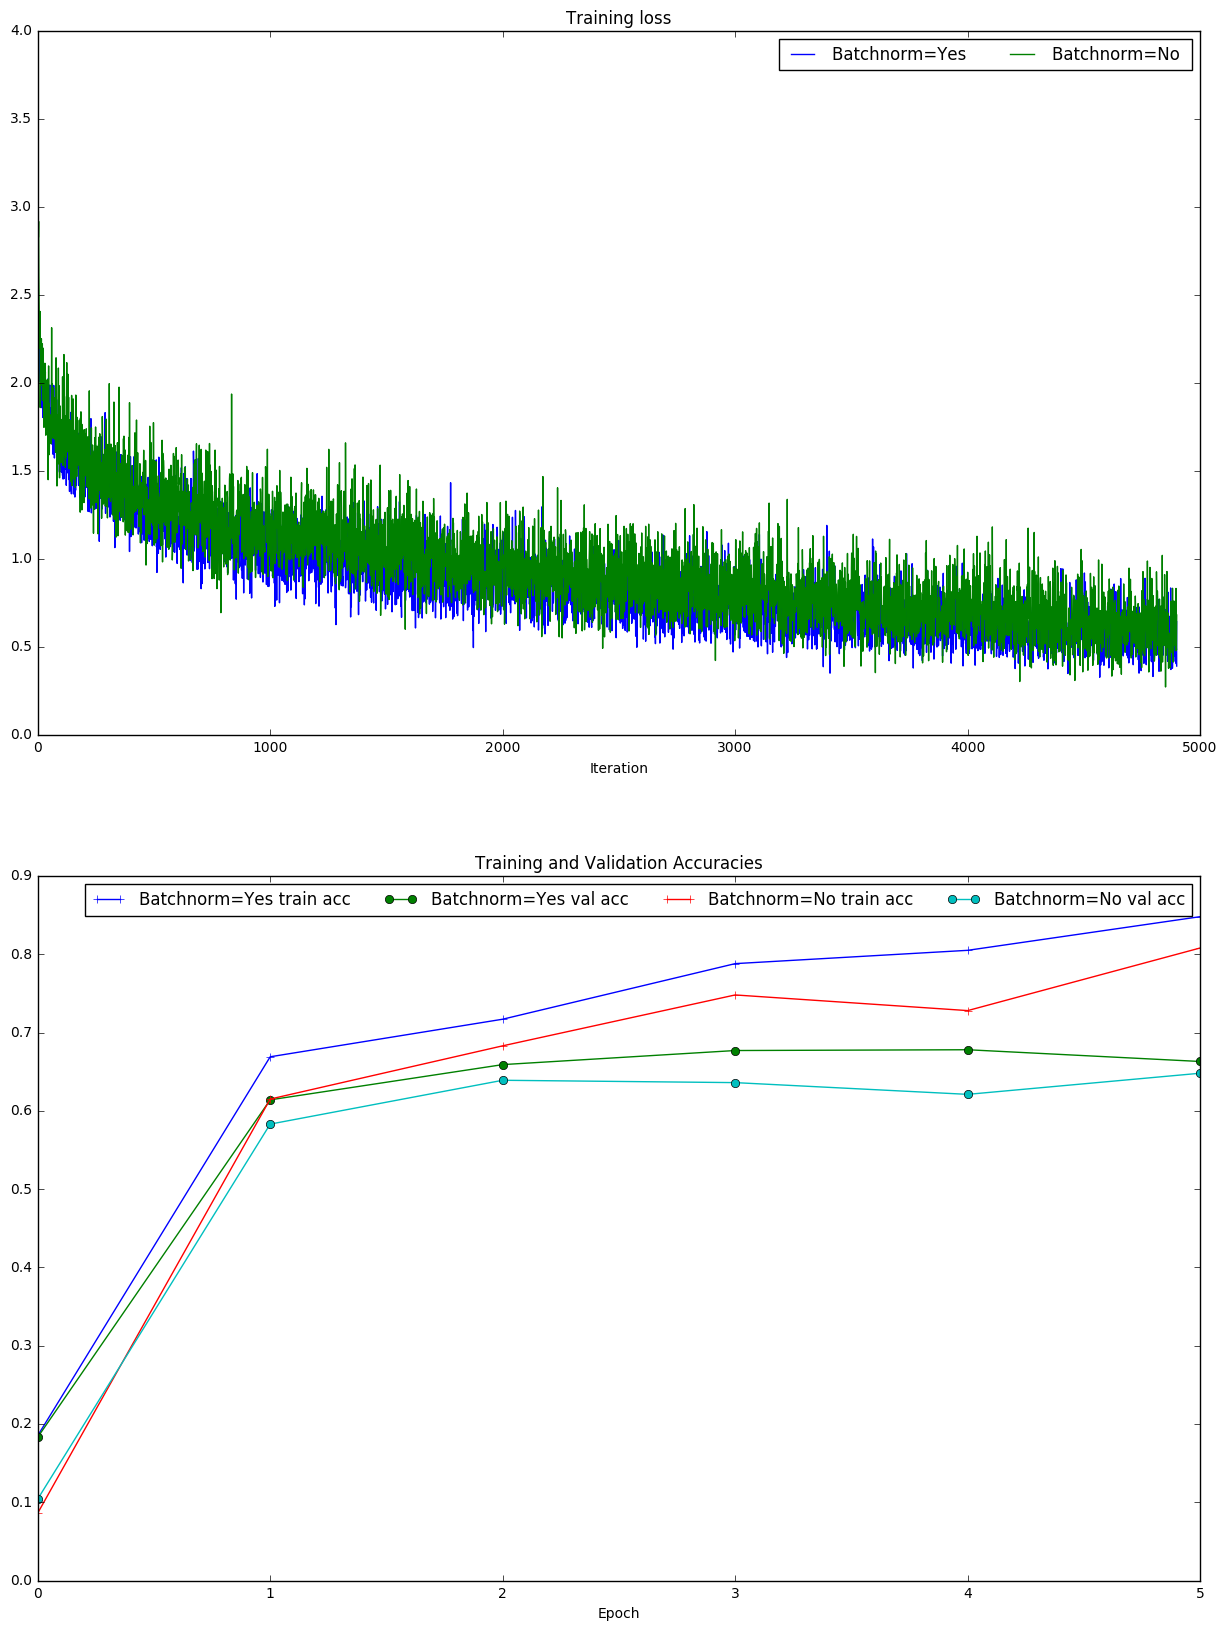

In [74]:
# Print out results.
for param,accuracy in sorted(results.iteritems()):
    n,f,i, lr, reg = param
    print 'Batchnorm = %s val accuracy: %f' % accuracy
print 'best validation accuracy achieved during cross-validation: %f' % best_val

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')

for items, solver in solvers.iteritems():
  print 
  plt.subplot(2, 1, 1)
  label = "Batchnorm=%s " % items[0]
  plt.plot(solver.loss_history, '-', label=label)
  
  plt.subplot(2, 1, 2)
  plt.plot(solver.train_acc_history, '-+', label=label+"train acc")

  plt.subplot(2, 1, 2)
  plt.plot(solver.val_acc_history, '-o', label=label+"val acc")
  
for i in [1, 2]:
  plt.subplot(2, 1, i)
  plt.legend(loc='best', ncol=4)
plt.gcf().set_size_inches(15, 20)
plt.show()

In [105]:
# Train identical nets with all possible dropout and batch norm combinations

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
batchnorm = [False, True]
for dropout in dropout_choices:
    for bn in batchnorm:

        model = ThreeLayerConvNet(hidden_dim=500, weight_scale=1e-2, dropout=dropout, use_batchnorm=bn)
        solver = Solver(model, small_data,
                num_epochs=25, batch_size=100,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=100)
        solver.train()
        solvers[(dropout,bn)] = solver

(Iteration 1 / 125) loss: 2.421334
(Epoch 0 / 25) train acc: 0.204000; val_acc: 0.152000
(Epoch 1 / 25) train acc: 0.366000; val_acc: 0.254000
(Epoch 2 / 25) train acc: 0.488000; val_acc: 0.282000
(Epoch 3 / 25) train acc: 0.566000; val_acc: 0.337000
(Epoch 4 / 25) train acc: 0.618000; val_acc: 0.319000
(Epoch 5 / 25) train acc: 0.704000; val_acc: 0.357000
(Epoch 6 / 25) train acc: 0.762000; val_acc: 0.328000
(Epoch 7 / 25) train acc: 0.798000; val_acc: 0.350000
(Epoch 8 / 25) train acc: 0.830000; val_acc: 0.323000
(Epoch 9 / 25) train acc: 0.884000; val_acc: 0.355000
(Epoch 10 / 25) train acc: 0.912000; val_acc: 0.350000
(Epoch 11 / 25) train acc: 0.942000; val_acc: 0.359000
(Epoch 12 / 25) train acc: 0.956000; val_acc: 0.351000
(Epoch 13 / 25) train acc: 0.972000; val_acc: 0.358000
(Epoch 14 / 25) train acc: 0.986000; val_acc: 0.355000
(Epoch 15 / 25) train acc: 0.988000; val_acc: 0.347000
(Epoch 16 / 25) train acc: 0.988000; val_acc: 0.369000
(Epoch 17 / 25) train acc: 0.992000; val

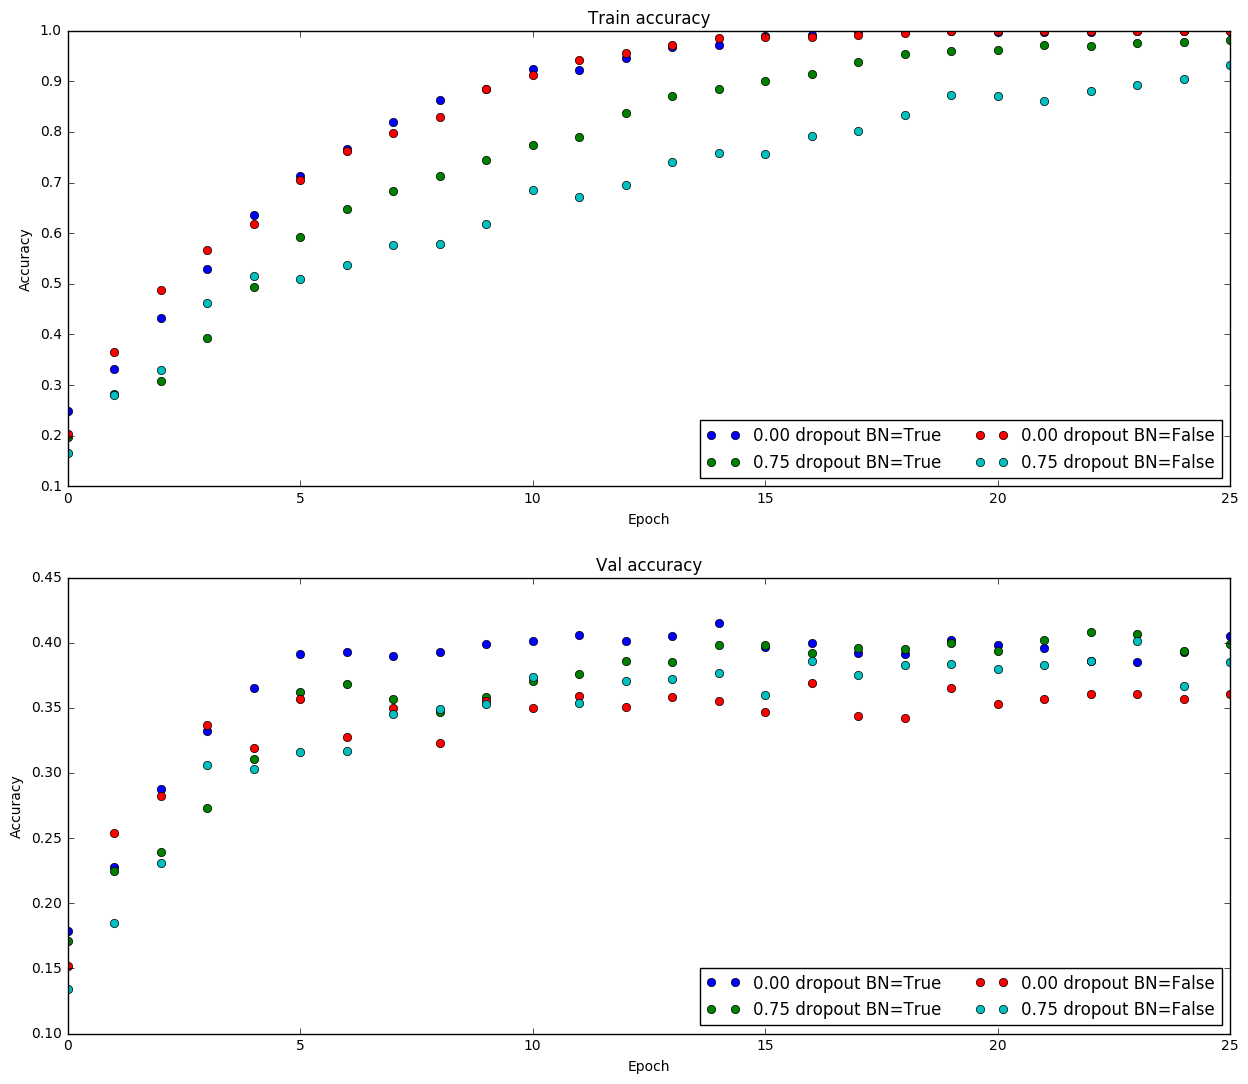

In [108]:
# Plot train and validation accuracies of the two models
plt.subplot(3, 1, 1)
for items, solver in solvers.iteritems():
  plt.plot(solvers[items].train_acc_history, 'o', label='%.2f dropout BN=%s' % (items[0], items[1]))
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for items, solver in solvers.iteritems():
  plt.plot(solvers[items].val_acc_history, 'o', label='%.2f dropout BN=%s' % (items[0], items[1]))
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 20)
plt.show()

# Value Add of Batch Norm and Dropout in 3 Layer CNN

No Dropout and No Batch Norm:  
(Epoch 25 / 25) train acc: 1.000000; val_acc: 0.361000  

No Dropout and Batch Norm:  
(Epoch 25 / 25) train acc: 1.000000; val_acc: 0.405000 

0.75 Dropout and No Batch Norm:  
(Epoch 25 / 25) train acc: 0.932000; val_acc: 0.385000  

0.75 Dropout and Batch Norm:  
(Epoch 25 / 25) train acc: 0.982000; val_acc: 0.399000

Conclusion:  
* Both batch normalization and dropout are used to address overfitting of training data.
* Batch normalization improves validation accuracy without sacrificing training accuracy.
* Batch normalization can be used on its own and may remove the need for dropout
